<a href="https://colab.research.google.com/github/Preteka/Deep-Learning-Lab/blob/main/dl10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/10 | Gen Loss: 1.1682 | Disc Loss: 0.2248


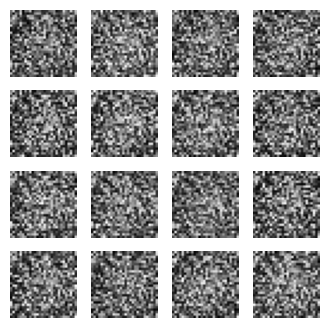

Epoch 2/10 | Gen Loss: 1.3248 | Disc Loss: 0.2212


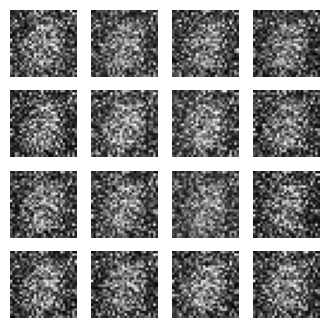

Epoch 3/10 | Gen Loss: 1.2188 | Disc Loss: 0.2738


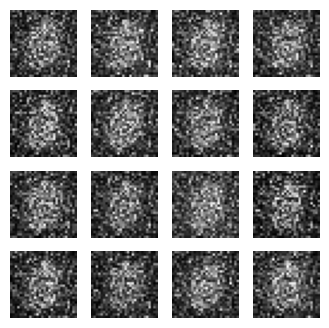

Epoch 4/10 | Gen Loss: 1.0084 | Disc Loss: 0.3873


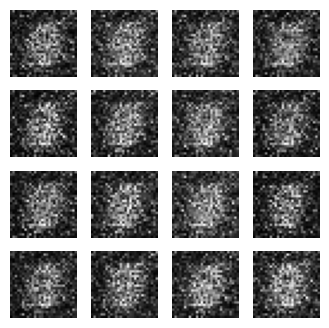

Epoch 5/10 | Gen Loss: 1.1134 | Disc Loss: 0.3373


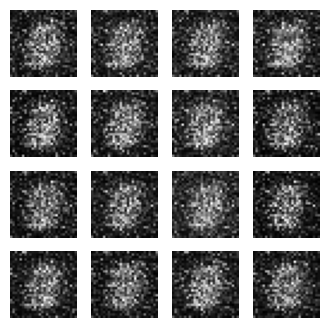

Epoch 6/10 | Gen Loss: 1.1448 | Disc Loss: 0.3833


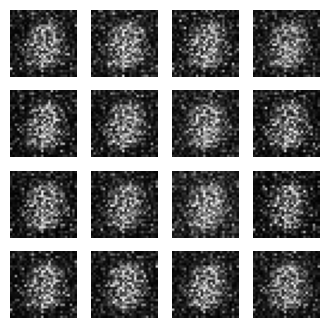

Epoch 7/10 | Gen Loss: 1.2386 | Disc Loss: 0.3452


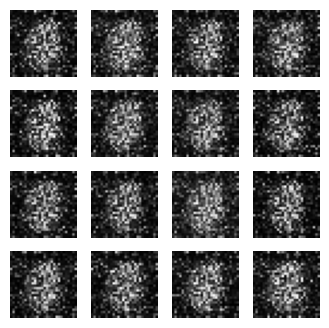

Epoch 8/10 | Gen Loss: 1.2526 | Disc Loss: 0.3127


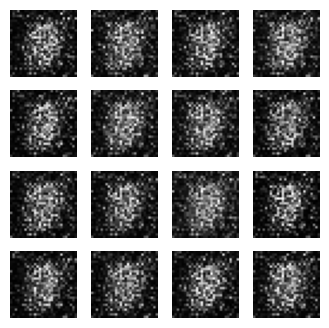

Epoch 9/10 | Gen Loss: 1.4957 | Disc Loss: 0.3337


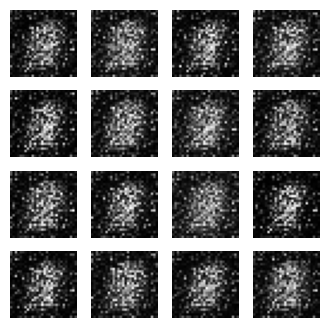

Epoch 10/10 | Gen Loss: 1.2327 | Disc Loss: 0.3292


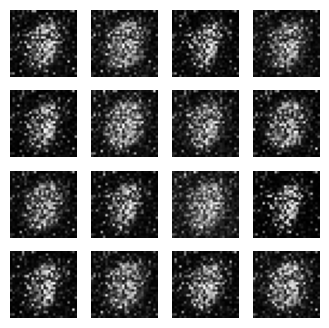

In [2]:
# Simple GAN for MNIST digits
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# ---------------- Load and preprocess MNIST ----------------
(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = (X_train.astype("float32") - 127.5) / 127.5   # normalize to [-1, 1]
X_train = np.expand_dims(X_train, axis=-1)              # (60000, 28, 28, 1)

BUFFER_SIZE = 60000
BATCH_SIZE = 128
LATENT_DIM = 100   # size of noise vector

dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# ---------------- Generator ----------------
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(128, activation="relu", input_shape=(LATENT_DIM,)),
        layers.Dense(28*28, activation="tanh"),
        layers.Reshape((28, 28, 1))
    ])
    return model

# ---------------- Discriminator ----------------
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Flatten(input_shape=(28,28,1)),
        layers.Dense(128, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    return model

generator = build_generator()
discriminator = build_discriminator()

# ---------------- Loss & Optimizers ----------------
cross_entropy = tf.keras.losses.BinaryCrossentropy()
g_optimizer = tf.keras.optimizers.Adam(1e-4)
d_optimizer = tf.keras.optimizers.Adam(1e-4)

# ---------------- Training Step ----------------
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        generated = generator(noise, training=True)

        real_out = discriminator(images, training=True)
        fake_out = discriminator(generated, training=True)

        g_loss = cross_entropy(tf.ones_like(fake_out), fake_out)
        d_loss = (cross_entropy(tf.ones_like(real_out), real_out) +
                  cross_entropy(tf.zeros_like(fake_out), fake_out)) / 2

    grads_g = g_tape.gradient(g_loss, generator.trainable_variables)
    grads_d = d_tape.gradient(d_loss, discriminator.trainable_variables)
    g_optimizer.apply_gradients(zip(grads_g, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(grads_d, discriminator.trainable_variables))
    return g_loss, d_loss

# ---------------- Training Loop ----------------
EPOCHS = 10
seed = tf.random.normal([16, LATENT_DIM])  # for monitoring progress

def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch)
        print(f"Epoch {epoch+1}/{epochs} | Gen Loss: {g_loss:.4f} | Disc Loss: {d_loss:.4f}")
        generate_and_plot(generator, seed)

# ---------------- Generate & Plot ----------------
def generate_and_plot(model, test_input):
    preds = model(test_input, training=False)
    preds = (preds + 1) / 2.0   # back to [0,1]
    plt.figure(figsize=(4,4))
    for i in range(preds.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(preds[i,:,:,0], cmap="gray")
        plt.axis("off")
    plt.show()

# ---------------- Run Training ----------------
train(dataset, EPOCHS)
